In [108]:
# imports
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import wandb
import copy
import os, sys, pathlib
import yaml
import json
import requests

from deq2ff.plotting.style import (
    set_seaborn_style,
    PALETTE,
    entity,
    projectmd,
    projectoc,
    plotfolder,
    human_labels,
    set_style_after,
    myrc,
)
from deq2ff.plotting.dashboard import get_runs_from_wandb, filter_best_runs

nans = ["NaN", pd.NA, None, float("inf"), np.nan]



In [109]:
# Config
project = projectoc

if project == projectmd:
    error_metric = "summary.test_f_mae"
elif project == projectoc:
    # summary.train/forces_mae, val, 
    error_metric = "summary.val/forces_mae"

In [110]:
# set sns color palette to one blue, three shades of orange
# sns.set_palette(sns.color_palette(["#1f77b4", "#ff7f0e", "#ffbb78", "#2ca02c"]))
# sns.set_palette(sns.color_palette(["#1f77b4", "#E97451", "#E3963E", "#FFC000"]))
sns.set_palette(sns.color_palette(["#1f77b4", "#E97451", "#FFC000", "#EC5800"]))

In [111]:
# project = projectmd
# df = get_runs_from_wandb(project=project, download_data=False)

df = get_runs_from_wandb(project=project, download_data=False)


Loaded dataframe.


In [112]:
# remove all rows where nothing got logged
print(df.shape)
if project == projectmd:
    df = df[~df["summary.epoch"].isna()]
elif project == projectoc:
    df = df[~df["config.task.dataset"].isna()]
    # discard runs where no test error was logged
    df = df[~df[error_metric].isna()]
else:
    raise ValueError("Unknown project")
print(df.shape)

(63, 626)
(51, 626)


In [113]:
# df

In [114]:
# [k for k in df.keys() if k.startswith("summary.test")]
# [k for k in df.keys() if k.startswith("summary.val")]

In [115]:
# [k for k in df.keys() if k.startswith("config.deq_kwargs")]

In [116]:
# df["config.model_is_deq"] = df["config.model_is_deq"].astype(bool)
# df["config.model_is_deq"]
# df["config.model_is_deq"]
# df["config.model.num_layers"]


In [117]:
# add a column "Model" that combines model_is_deq and num_layers
# if model_is_deq is False, then Model is "E", else "DEQ"
df["Model"] = df["config.model_is_deq"].apply(
    lambda x: "E" if not x else "DEQ"
) + df["config.model.num_layers"].apply(str) 

# add training progress to model name
# if project == projectmd:
#     df["Model"] = df["Model"] + " (" + df["summary.epoch"].apply(int).apply(str) + ")" 
# elif project == projectoc:
#     df["Model"] = df["Model"] + " (" + df["summary.train/step"].apply(
#             lambda x: str(int(x // 100))
#         ) + "k)"

# replace nans with 0
df["config.deq_kwargs.n_states"] = df["config.deq_kwargs.n_states"].replace(nans, 0)

In [118]:
# df[["run_name", "config.target"]]

# # print row 318
# df.iloc[318][["run_name", "config.target", "summary.epoch"]]

In [119]:
# df["run_name"]

In [120]:
# loop over rows in df
# for i, row in df.iterrows():
#     x = row["run_name"]
#     if "data-" in x:
#         y = x[x.find("data-") + len("data-"):].split(" ")[0]
#         print(x, ":", y)

In [121]:
# for OC20 determine how much data was used
if project == projectoc:
    df["config.target"] = "0" # placeholder
    
    # earlier runs just have data-2M in the run name
    tempdf = df[df["run_name"].str.contains("data-")]
    tempdf["config.target"] = tempdf["run_name"].apply(
        # get the first word after data- in the run name
        lambda x: x[x.find("data-") + len("data-"):].split(" ")[0]
        if "data-" in x else tempdf["config.target"]
    )
    # overwrite the target in the main df
    df.loc[tempdf.index, "config.target"] = tempdf["config.target"]

    # later runs have config.dataset_size, config.dataset.split
    # overwrite where possible
    if "config.dataset.split" in df.columns:
        # fill in config.target where config.dataset.split is not nan else leave it
        df["config.target"] = df["config.dataset.split"].fillna(df["config.target"])

    if "config.dataset_size" in df.columns:
        # is independent of maxdata
        df["config.target"] = df["config.dataset_size"].apply(
            lambda x: f"{int(x / 1000)}k" if pd.notna(x) else df["config.target"]
        )
    
    # where target=0, fill in "200k" as default
    print(f"replacing {df[df['config.target'] == '0'].shape[0]}/{df.shape[0]} 0's with 200k")
    df["config.target"] = df["config.target"].replace("0", "200k")
    # df["config.target"] = df["config.target"].apply(lambda x: f"200k" if x == '0' else x)

    # config.optim.maxdata
    print(f'Adding maxdata to target:')
    if "config.optim.maxdata" in df.columns:
        # where maxdata is > 0, append it to the target
        tempdf = df[df["config.optim.maxdata"] > 0]
        tempdf["config.target"] = tempdf["config.optim.maxdata"].apply(
            lambda x: f"{int(x / 1000)}k/" # if x > 0 else ""
        )
        df.loc[tempdf.index, "config.target"] = tempdf["config.target"] + df["config.target"]
    
    print(f"Adding optim.max_epochs to target:")
    df["config.target"] = df["config.target"] + " e" + df["config.optim.max_epochs"].apply(int).apply(str)

"""
SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead
Chained assignment: The use of more than one indexing operation back-to-back & a setting operation.
"""

# df["config.target"]

replacing 44/51 0's with 200k
Adding maxdata to target:
Adding optim.max_epochs to target:


/tmp/ipykernel_164808/2638375476.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tempdf["config.target"] = tempdf["run_name"].apply(


'\nSettingWithCopyWarning: \nA value is trying to be set on a copy of a slice from a DataFrame.\nTry using .loc[row_indexer,col_indexer] = value instead\nChained assignment: The use of more than one indexing operation back-to-back & a setting operation.\n'

In [122]:
if project == projectoc:
    df["config.dname"] = "oc20"

In [123]:
# add and sort by num_atoms of target molecule

if project == projectmd:
    # load datasets/statistics.json
    # equilibrium-forcefields/src/deq2ff/plotting/dashboard.ipynb
    # equilibrium-forcefields/datasets/statistics.json
    # get folder of ipynb
    fpath = "/ssd/gen/equilibrium-forcefields/datasets/statistics.json"
    print(fpath)
    with open(fpath, "r") as f:
        statistics = json.load(f)

    # print(statistics)
    statistics = {**statistics["md17"], **statistics["md22"]}
    print(statistics)

    # add num_atoms to df based on target
    max_radius = df["config.model.max_radius"].unique()[0]
    max_radius = str(float(max_radius))

    # loop over rows
    # for i, row in df.iterrows():
    #     target = row["config.target"]
    #     print(i, target)
    #     num_atoms = statistics[target]
    #     num_atoms = num_atoms[max_radius]
    #     num_atoms = num_atoms["avg_node"]
    #     df.at[i, "num_atoms"] = num_atoms
    df["num_atoms"] = df["config.target"].apply(lambda x: statistics[x][max_radius]["avg_node"])

    # sort target by num_atoms
    df = df.sort_values(["num_atoms", "config.target"])

In [124]:
# df[["run_name", "config.target", error_metric]]

In [125]:
if project == projectmd:
    df_best_runs = filter_best_runs(
        df=df, error_metric=error_metric,
        anti_criteria={
            "config.decay_rate": 1,
        }
    )

elif project == projectoc:
    df_best_runs = filter_best_runs(
        df=df, error_metric=error_metric,
        criteria={
            "config.model.attn_alpha_channels": 64, # reg
        },
        anti_criteria={
            "config.decay_rate": 1, # constlr
        }
    )

In [126]:
df_best_runs[["run_name", "config.target", error_metric]]

,run_name,config.target,summary.val/forces_mae
36,pDEQs apc reg,200k e3,0.042665
54,pDEQs ap numlayers-2 reg,200k e3,0.048052
50,pEs dd numlayers-1 reg,200k e3,0.051899
10,pEs dd reg,200k e3,0.044912
53,pEs dd numlayers-8 reg,200k e3,0.044600
57,pDEQs apt optimmaxepochs-12 reg,200k e12,0.032058
3,pEs dd optimmaxepochs-12 reg,200k e12,0.033703
59,pDEQs ap data-2M nstates-3 optimbatchsize-16 o...,2M e1,0.040397
20,pEs dd data-2M optimbatchsize-16 optimmaxepoch...,2M e1,0.033411
23,pDEQs ap optimmaxepochs-1 reg,200k e1,0.056698


In [127]:
# mark the run with the lowest error_metric for each target
df_best_runs["sota"] = False
for target in df_best_runs["config.target"].unique():
    _df_best = df_best_runs[df_best_runs["config.target"] == target]
    _df_best = _df_best[_df_best[error_metric] == _df_best[error_metric].min()]
    df_best_runs.loc[_df_best.index, "sota"] = True

# defragment
df_best_runs = df_best_runs.copy()

/tmp/ipykernel_164808/2366802670.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_best_runs["sota"] = False


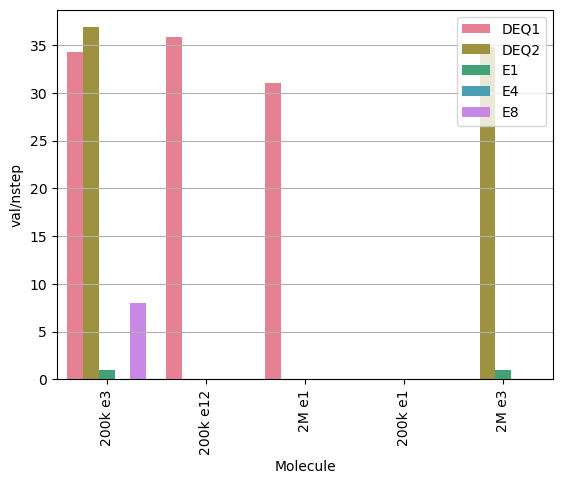

In [128]:
# plot n_step
# grouped barchart, with target as group, and model as hue
if project == projectmd:
    y = "summary.avg_n_fsolver_steps_test_fpreuse"
elif project == projectoc:
    y = "summary.val/nstep"

x = "config.target"
hue = "Model"
data = df_best_runs.copy()

# plot
fig, ax = plt.subplots()
sns.barplot(x=x, y=y, hue=hue, data=data, ax=ax)
plt.legend()
plt.xlabel(human_labels(x))
plt.ylabel(human_labels(y))

# vertical xtick labels
plt.xticks(rotation=90)

# horizontal grid
plt.grid(axis="y")

# make a separate plot for each target

# save
# plt.savefig(f"{plotfolder}/n_steps.png")
plt.show()

# print names of plotted runs
# data["run_name"]

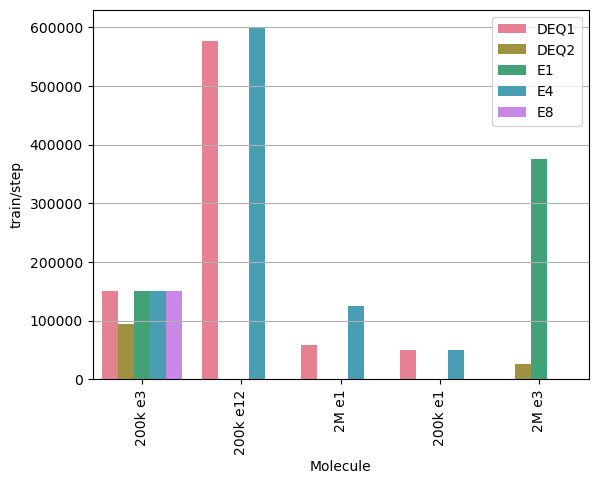

In [129]:
# plot how far training has progressed (steps / epochs)
if project == projectmd:
    y = "summary.epoch"
elif project == projectoc:
    y = "summary.train/step"
x = "config.target"
hue = "Model"
data = df_best_runs.copy()

# plot
fig, ax = plt.subplots()
sns.barplot(x=x, y=y, hue=hue, data=data, ax=ax)
plt.legend()
plt.xlabel(human_labels(x))
plt.ylabel(human_labels(y))

# vertical xtick labels
plt.xticks(rotation=90)

# horizontal grid
plt.grid(axis="y")

# make a separate plot for each target

# save
plt.show()

In [130]:
# df_best_runs[["run_name", "config.target", "Model", "summary.train/step", "config.optim.max_epochs", "summary.train/epoch"]]

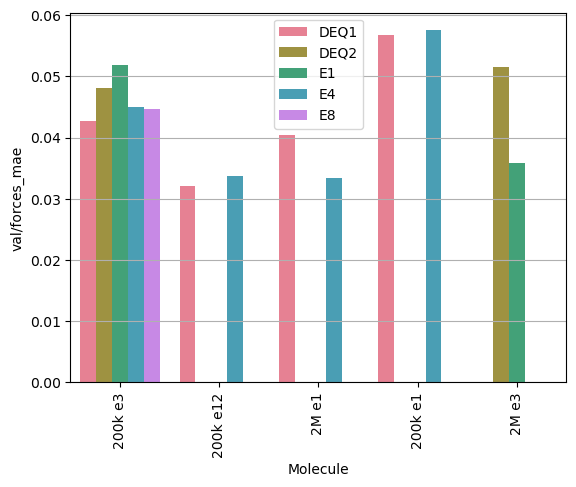

In [131]:
# plot accuracy
# grouped barchart, with target as group, and model as hue
y = error_metric
x = "config.target"
hue = "Model"
data = df_best_runs.copy()

# plot
fig, ax = plt.subplots()
sns.barplot(x=x, y=y, hue=hue, data=data, ax=ax)
plt.legend()
plt.xlabel(human_labels(x))
plt.ylabel(human_labels(y))

# vertical xtick labels
plt.xticks(rotation=90)

# horizontal grid
plt.grid(axis="y")

# make a separate plot for each target

# save
# plt.savefig(f"{plotfolder}/n_steps.png")
plt.show()

In [132]:
# plot accuracy, normalized for each target

# grouped barchart, with target as group, and model as hue
y = error_metric
x = "config.target"
hue = "Model"
data = df_best_runs.copy()

# normalize
# data["summary.test_f_mae"] = data.groupby("config.target")["summary.test_f_mae"].transform(lambda x: (x - x.min()) / (x.max() - x.min()))
data["summary.test_f_mae"] = data.groupby("config.target")["summary.test_f_mae"].transform(lambda x: x / x.mean())

# plot
fig, ax = plt.subplots()
sns.barplot(x=x, y=y, hue=hue, data=data, ax=ax)
plt.legend()
plt.xlabel(human_labels(x))
plt.ylabel(human_labels(y))

# where "sota" is True, mark the run with a green star
# for target in data["config.target"].unique():
#     _df = data[data["config.target"] == target]
#     _df = _df[_df["sota"] == True]
#     for index in _df.index:
#         ax.plot(index, _df.loc[index, y], "o", color="green", markersize=10)

# vertical xtick labels
plt.xticks(rotation=90)

# horizontal grid
plt.grid(axis="y")

# make a separate plot for each target

# save
# plt.savefig(f"{plotfolder}/n_steps.png")
plt.show()

KeyError: 'Column not found: summary.test_f_mae'

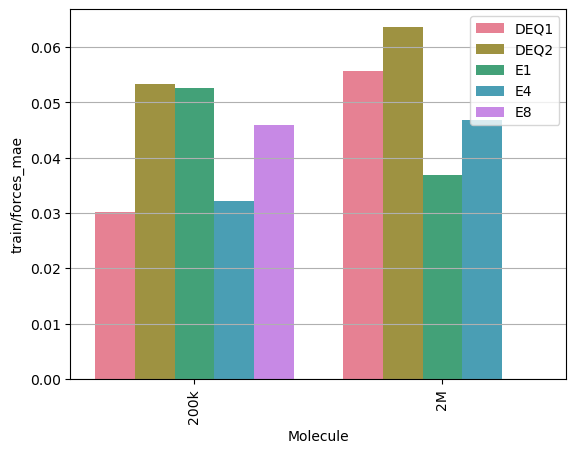

In [90]:
# plot train_loss_f

# grouped barchart, with target as group, and model as hue
if project == projectmd:
    y = "summary.train_loss_f"
elif project == projectoc:
    y = "summary.train/forces_mae"
x = "config.target"
hue = "Model"

data = df_best_runs.copy()
# DEQ is in the model name
# data = data["DEQ" in data["Model"]]
# data = data[df["Model"].str.startswith('DEQ')]

# plot
fig, ax = plt.subplots()
sns.barplot(x=x, y=y, hue=hue, data=data, ax=ax)
plt.legend()
plt.xlabel(human_labels(x))
plt.ylabel(human_labels(y))

# vertical xtick labels
plt.xticks(rotation=90)

# horizontal grid
plt.grid(axis="y")

# make a separate plot for each target

# save
# plt.savefig(f"{plotfolder}/train_loss_f.png")
plt.show()

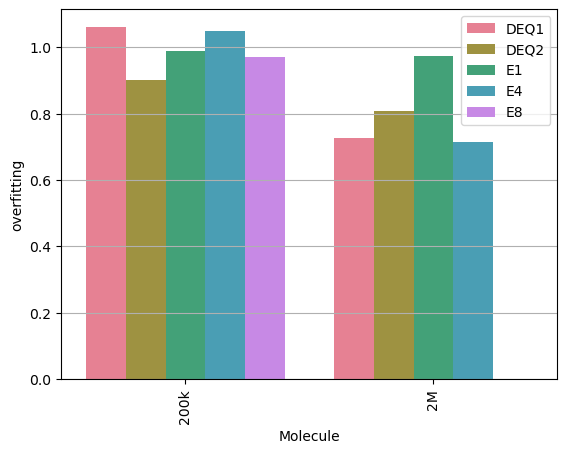

In [92]:
# overfitting = test_loss / train_loss
if project == projectmd:
    df_best_runs["overfitting"] = df_best_runs["summary.test_f_mae"] / df_best_runs["summary.train_loss_f"]
elif project == projectoc:
    df_best_runs["overfitting"] = df_best_runs["summary.val/forces_mae"] / df_best_runs["summary.train/forces_mae"]

y = "overfitting"
x = "config.target"
hue = "Model"

data = df_best_runs.copy()
# DEQ is in the model name
# data = data["DEQ" in data["Model"]]
# data = data[df["Model"].str.startswith('DEQ')]

# plot
fig, ax = plt.subplots()
sns.barplot(x=x, y=y, hue=hue, data=data, ax=ax)
plt.legend()
plt.xlabel(human_labels(x))
plt.ylabel(human_labels(y))

# vertical xtick labels
plt.xticks(rotation=90)

# horizontal grid
plt.grid(axis="y")

# make a separate plot for each target

# save
# plt.savefig(f"{plotfolder}/train_loss_f.png")
plt.show()

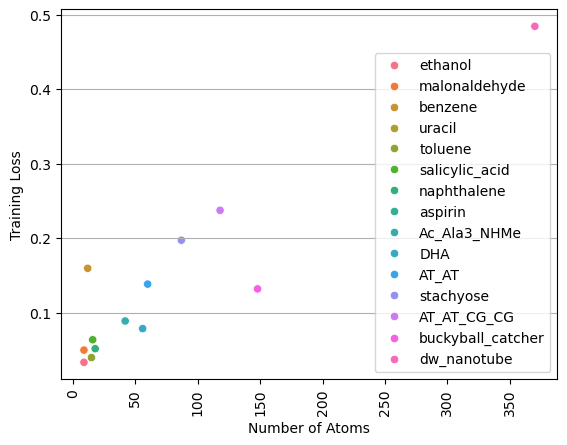

In [18]:
# plot
fig, ax = plt.subplots()
# sns.barplot(x=x, y=y, hue=hue, data=data, ax=ax)
# scatterplot 
x = "num_atoms"
y = "summary.train_loss_f"
hue = "config.target"
sns.scatterplot(x=x, y=y, hue=hue, data=data, ax=ax)
plt.legend()
plt.xlabel(human_labels(x))
plt.ylabel(human_labels(y))

# vertical xtick labels
plt.xticks(rotation=90)

# horizontal grid
plt.grid(axis="y")

# make a separate plot for each target

# save
# plt.savefig(f"{plotfolder}/train_loss_f.png")
plt.show()

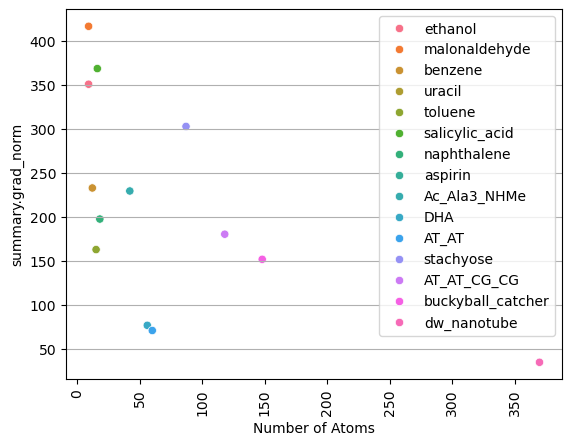

In [19]:
# plot
fig, ax = plt.subplots()
# sns.barplot(x=x, y=y, hue=hue, data=data, ax=ax)
# scatterplot 
x = "num_atoms"
y = "summary.grad_norm"
hue = "config.target"
sns.scatterplot(x=x, y=y, hue=hue, data=data, ax=ax)
plt.legend()
plt.xlabel(human_labels(x))
plt.ylabel(human_labels(y))

# vertical xtick labels
plt.xticks(rotation=90)

# horizontal grid
plt.grid(axis="y")

# make a separate plot for each target

# save
# plt.savefig(f"{plotfolder}/train_loss_f.png")
plt.show()

In [20]:
data["config.deq_kwargs.n_states"]

172    3.0
36     1.0
167    1.0
96     1.0
204    1.0
45     1.0
260    1.0
147    1.0
256    3.0
136    1.0
169    3.0
240    3.0
137    1.0
187    3.0
138    1.0
Name: config.deq_kwargs.n_states, dtype: float64

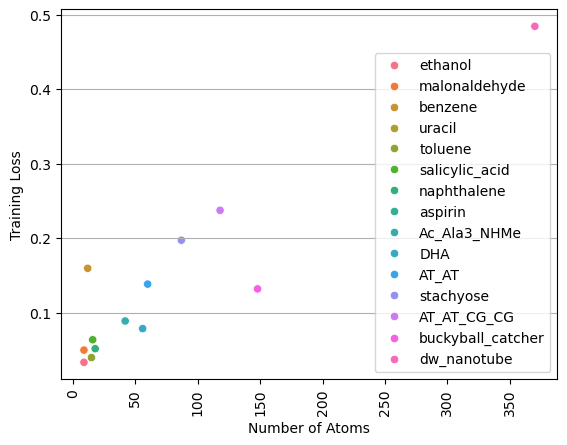

In [21]:
# plot
fig, ax = plt.subplots()
# sns.barplot(x=x, y=y, hue=hue, data=data, ax=ax)
# scatterplot 
x = "num_atoms"
y = "summary.train_loss_f"
hue = "config.target"
sns.scatterplot(x=x, y=y, hue=hue, data=data, ax=ax)
plt.legend()
plt.xlabel(human_labels(x))
plt.ylabel(human_labels(y))

# vertical xtick labels
plt.xticks(rotation=90)

# horizontal grid
plt.grid(axis="y")

# make a separate plot for each target

# save
# plt.savefig(f"{plotfolder}/train_loss_f.png")
plt.show()

In [22]:
# compare n_states=3 to no fpc

df_nstates = []

for target in df["config.target"].unique():
    criteriatarget = {"config.target": target}

    # best DEQ
    criteria_deq = {
        "config.model_is_deq": True, "config.model.num_layers": 1, 
        "config.deq_kwargs.n_states": 3, "config.deq_kwargs.f_tol": 1e-2,
        # "config.model.enc_ln": False # model.enc_ln=True
    }
    criteria_deq.update(criteriatarget)
    df_nstates = add_best_run(df, df_nstates, criteria_deq, error_metric)

    criteria_deq["config.deq_kwargs.n_states"] = 1.0
    criteria_deq.update(criteriatarget)
    df_nstates = add_best_run(df, df_nstates, criteria_deq, error_metric)

df_nstates = pd.concat(df_nstates)

# add n_states to "model" column
df_nstates["Model"] = df_nstates["Model"] + df_nstates["config.deq_kwargs.n_states"].apply(
    lambda x: f", n_states={x}" if x is not None else ""
)

# grouped barchart, with target as group, and model as hue
y = "summary.test_f_mae"
x = "config.target"
hue = "Model"
data = df_nstates.copy()

# plot
fig, ax = plt.subplots()
sns.barplot(x=x, y=y, hue=hue, data=data, ax=ax)
plt.legend()
plt.xlabel(human_labels(x))
plt.ylabel(human_labels(y))

# vertical xtick labels
plt.xticks(rotation=90)

# horizontal grid
plt.grid(axis="y")

# make a separate plot for each target

# save
# plt.savefig(f"{plotfolder}/.png")
plt.show()

TypeError: add_best_run() missing 1 required positional argument: 'metric'

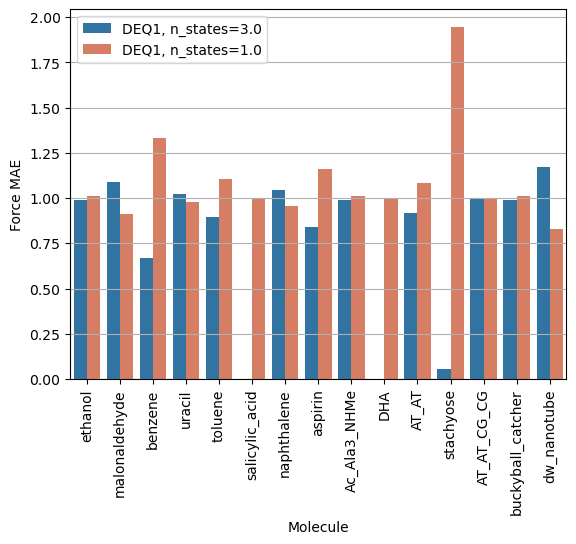

In [ ]:
# compare n_states=3 to no fpc

# norm data[y] for each target
# data[y] = data.groupby(x)[y].transform(lambda x: (x - x.min()) / (x.max() - x.min()))
data[y] = data.groupby(x)[y].transform(lambda x: x / x.mean())

# plot
fig, ax = plt.subplots()
sns.barplot(x=x, y=y, hue=hue, data=data, ax=ax)
plt.legend()
plt.xlabel(human_labels(x))
plt.ylabel(human_labels(y))

# vertical xtick labels
plt.xticks(rotation=90)

# horizontal grid
plt.grid(axis="y")

# make a separate plot for each target

# save
# plt.savefig(f"{plotfolder}/.png")
plt.show()